In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
from torch.optim import SGD
# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
%matplotlib notebook

from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D
from neurodiffeq.generators import Generator1D

# Objective
We find that F-principle stops our ANN from approximating a high-frequency function with high accuracy and performance.MARKIDIS tried to solve this problem bypassing the training for those high-frequency components and leave them for the traditional methods like Gauss-Sidel. 

Here we conduct an experiment on the Fourier transform of our trained ANNs into frequency field, to see whether an alternative approach is possible for us to eradicate this con.


# Experiments 

## Fourier transform a single ODE into frequency field 

See our ODE_function example, 
$$
F(u, t) = \frac{d^2u}{dt^2} + 9u = 0
$$

for

$$
u(0) = 0.0, \frac{du}{dt}|_{t=0} = 3.0
$$

The analytical solution is 

$$u = \sin(3t)$$

We can include higher order derivatives in our ODE with the `order` keyword of `diff`, which is defaulted to 1.

Initial condition on $\dfrac{du}{dt}$ can be specified with the `u_0_prime` keyword of `IVP`. 

<IPython.core.display.Javascript object>


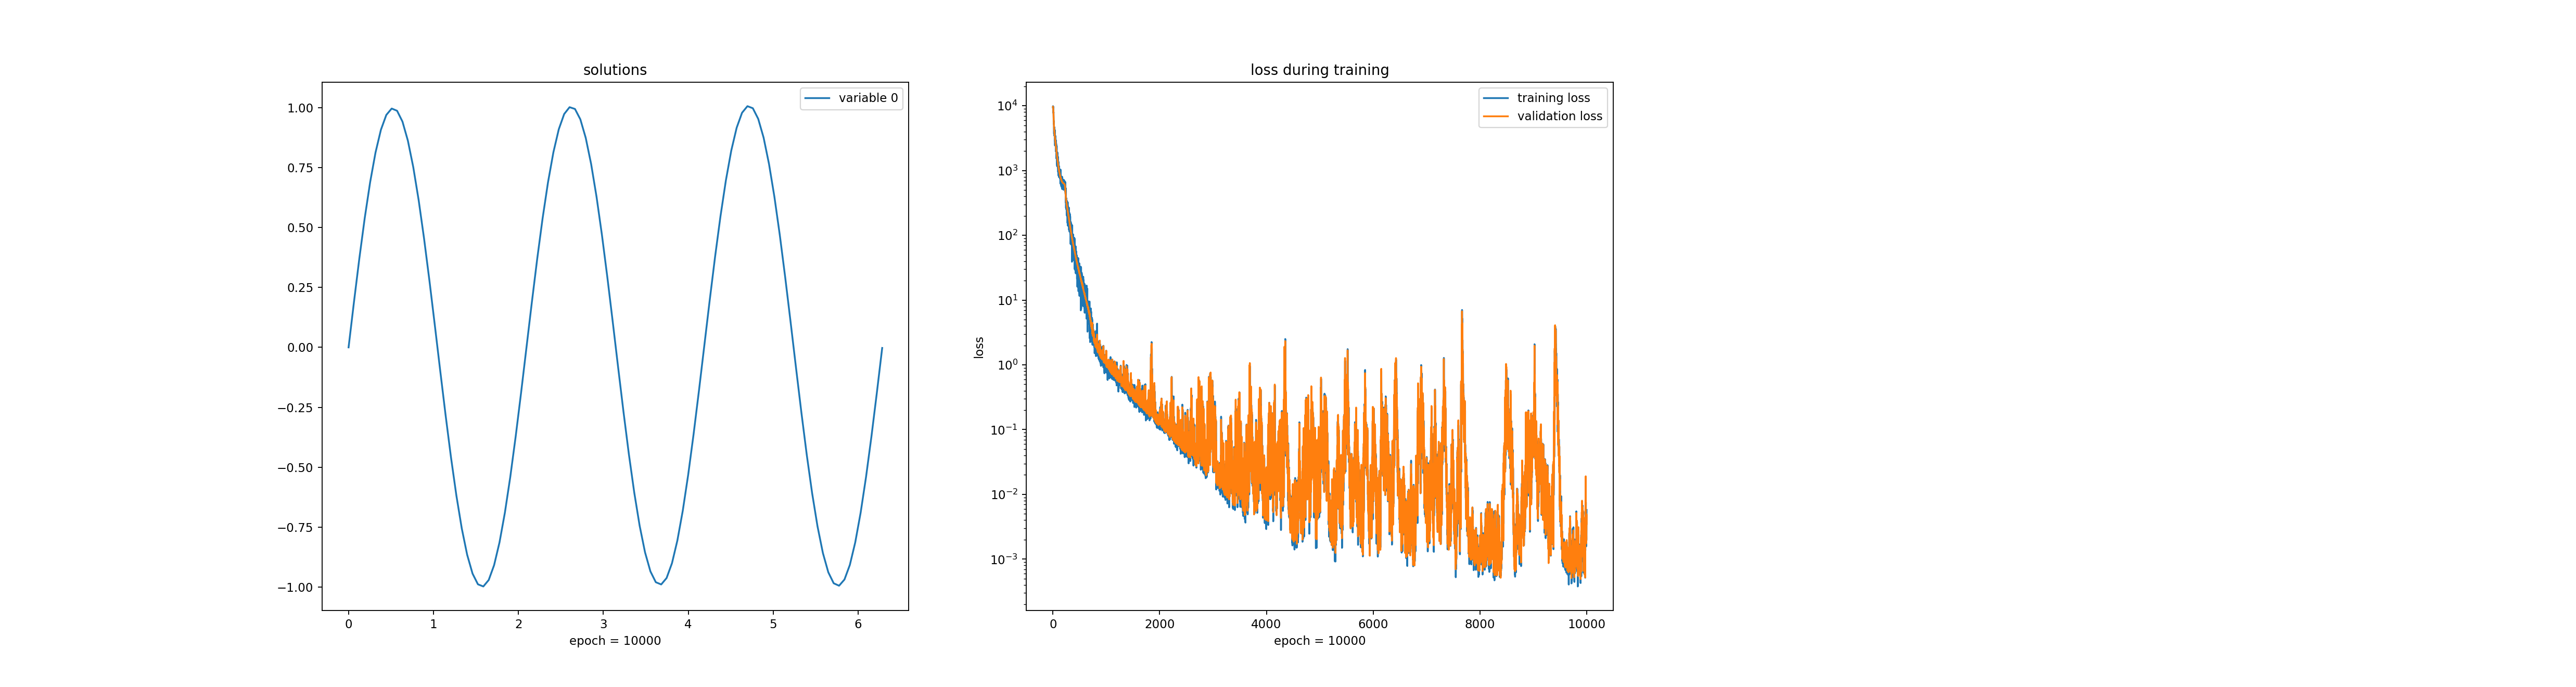

In [26]:
harmonic_oscillator = lambda u, t: [diff(u, t, order=2) + 9*u]
init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=3.0)]

# specify the training set and validation set
train_gen = Generator1D(size=128,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = Generator1D(size=256, t_min=0.0, t_max=2*np.pi, method='equally-spaced')

# specify the neural network architecture
nets_ho1 = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64, 64, 64, 64, 64), actv=SinActv)]

solver1 = Solver1D(
    ode_system=harmonic_oscillator, 
    conditions=init_val_ho, 
    t_min=0.0, t_max=2*np.pi, 
    nets=nets_ho1,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)


# Fit the solver (i.e., train the neural networks)
solver1.fit(
    max_epochs=10000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

# Get the solution
solution_ho1 = solver1.get_solution()

In [10]:
#from itertools import chain

LBFGS_ho = torch.optim.LBFGS(
    chain.from_iterable(n.parameters() for n in nets_ho1), # this gives all parameters in `nets`
    lr=0.001,                                          # learning rate                                   
)


In [11]:
from scipy import fft

In [23]:
ts = np.linspace(0, 2*np.pi, 10000)
fft_y=fft.ifft(solution_ho1(ts, to_numpy=True))                         #fast Fourier transform

<IPython.core.display.Javascript object>


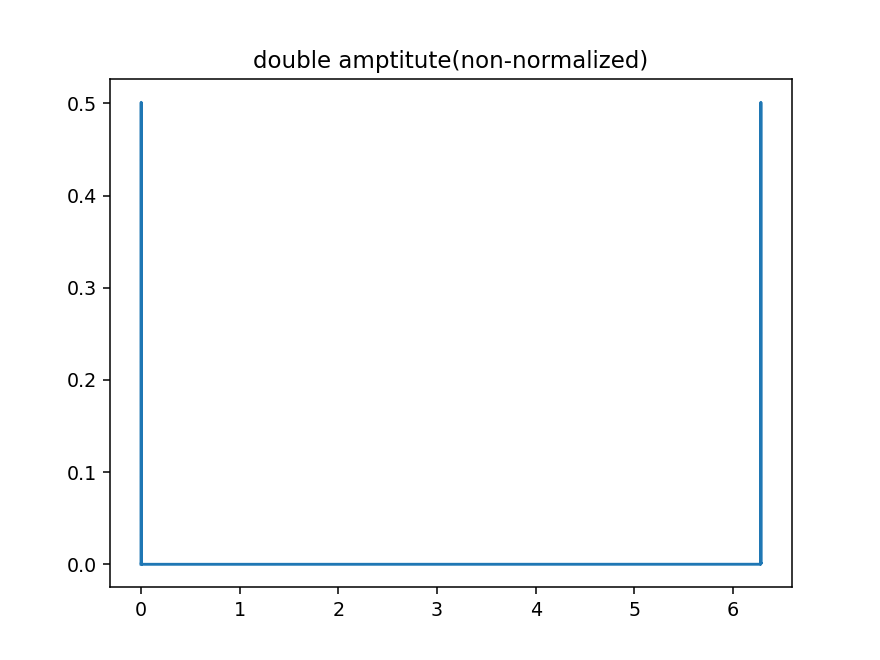

Text(0.5, 1.0, 'double amptitute(non-normalized)')

In [24]:
abs_y=np.abs(fft_y)                
         
plt.figure()
plt.plot(ts,abs_y)   
plt.title('double amptitute(non-normalized)')

From the diagram after inverse Fourier Transform of our neural function, it is feasible to denote the result in the frequency field.

How about training the PINNs in the frequency field? In this way, we could surpass the 'F-principle' problem.

##  Fourier transform a single PDE into frequency field

Here we solve 2-D Laplace equation on a Cartesian boundary with Dirichlet boundary condition:

$$
F(u, x, y) = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0
$$

for $(x, y) \in [0, 1] \times [0, 1]$

s.t.

$$
u(x, y)\bigg|_{x=0} = \sin(\pi y) \\
u(x, y)\bigg|_{x=1} = 0 \\
u(x, y)\bigg|_{y=0} = 0 \\
u(x, y)\bigg|_{y=1} = 0
$$

The analytical solution is

$$
u(x, y) = \frac{\sin(\pi y) \sinh(\pi(1-x))}{\sinh(\pi)}
$$

In [3]:
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.solvers import Solver2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
import torch

<IPython.core.display.Javascript object>


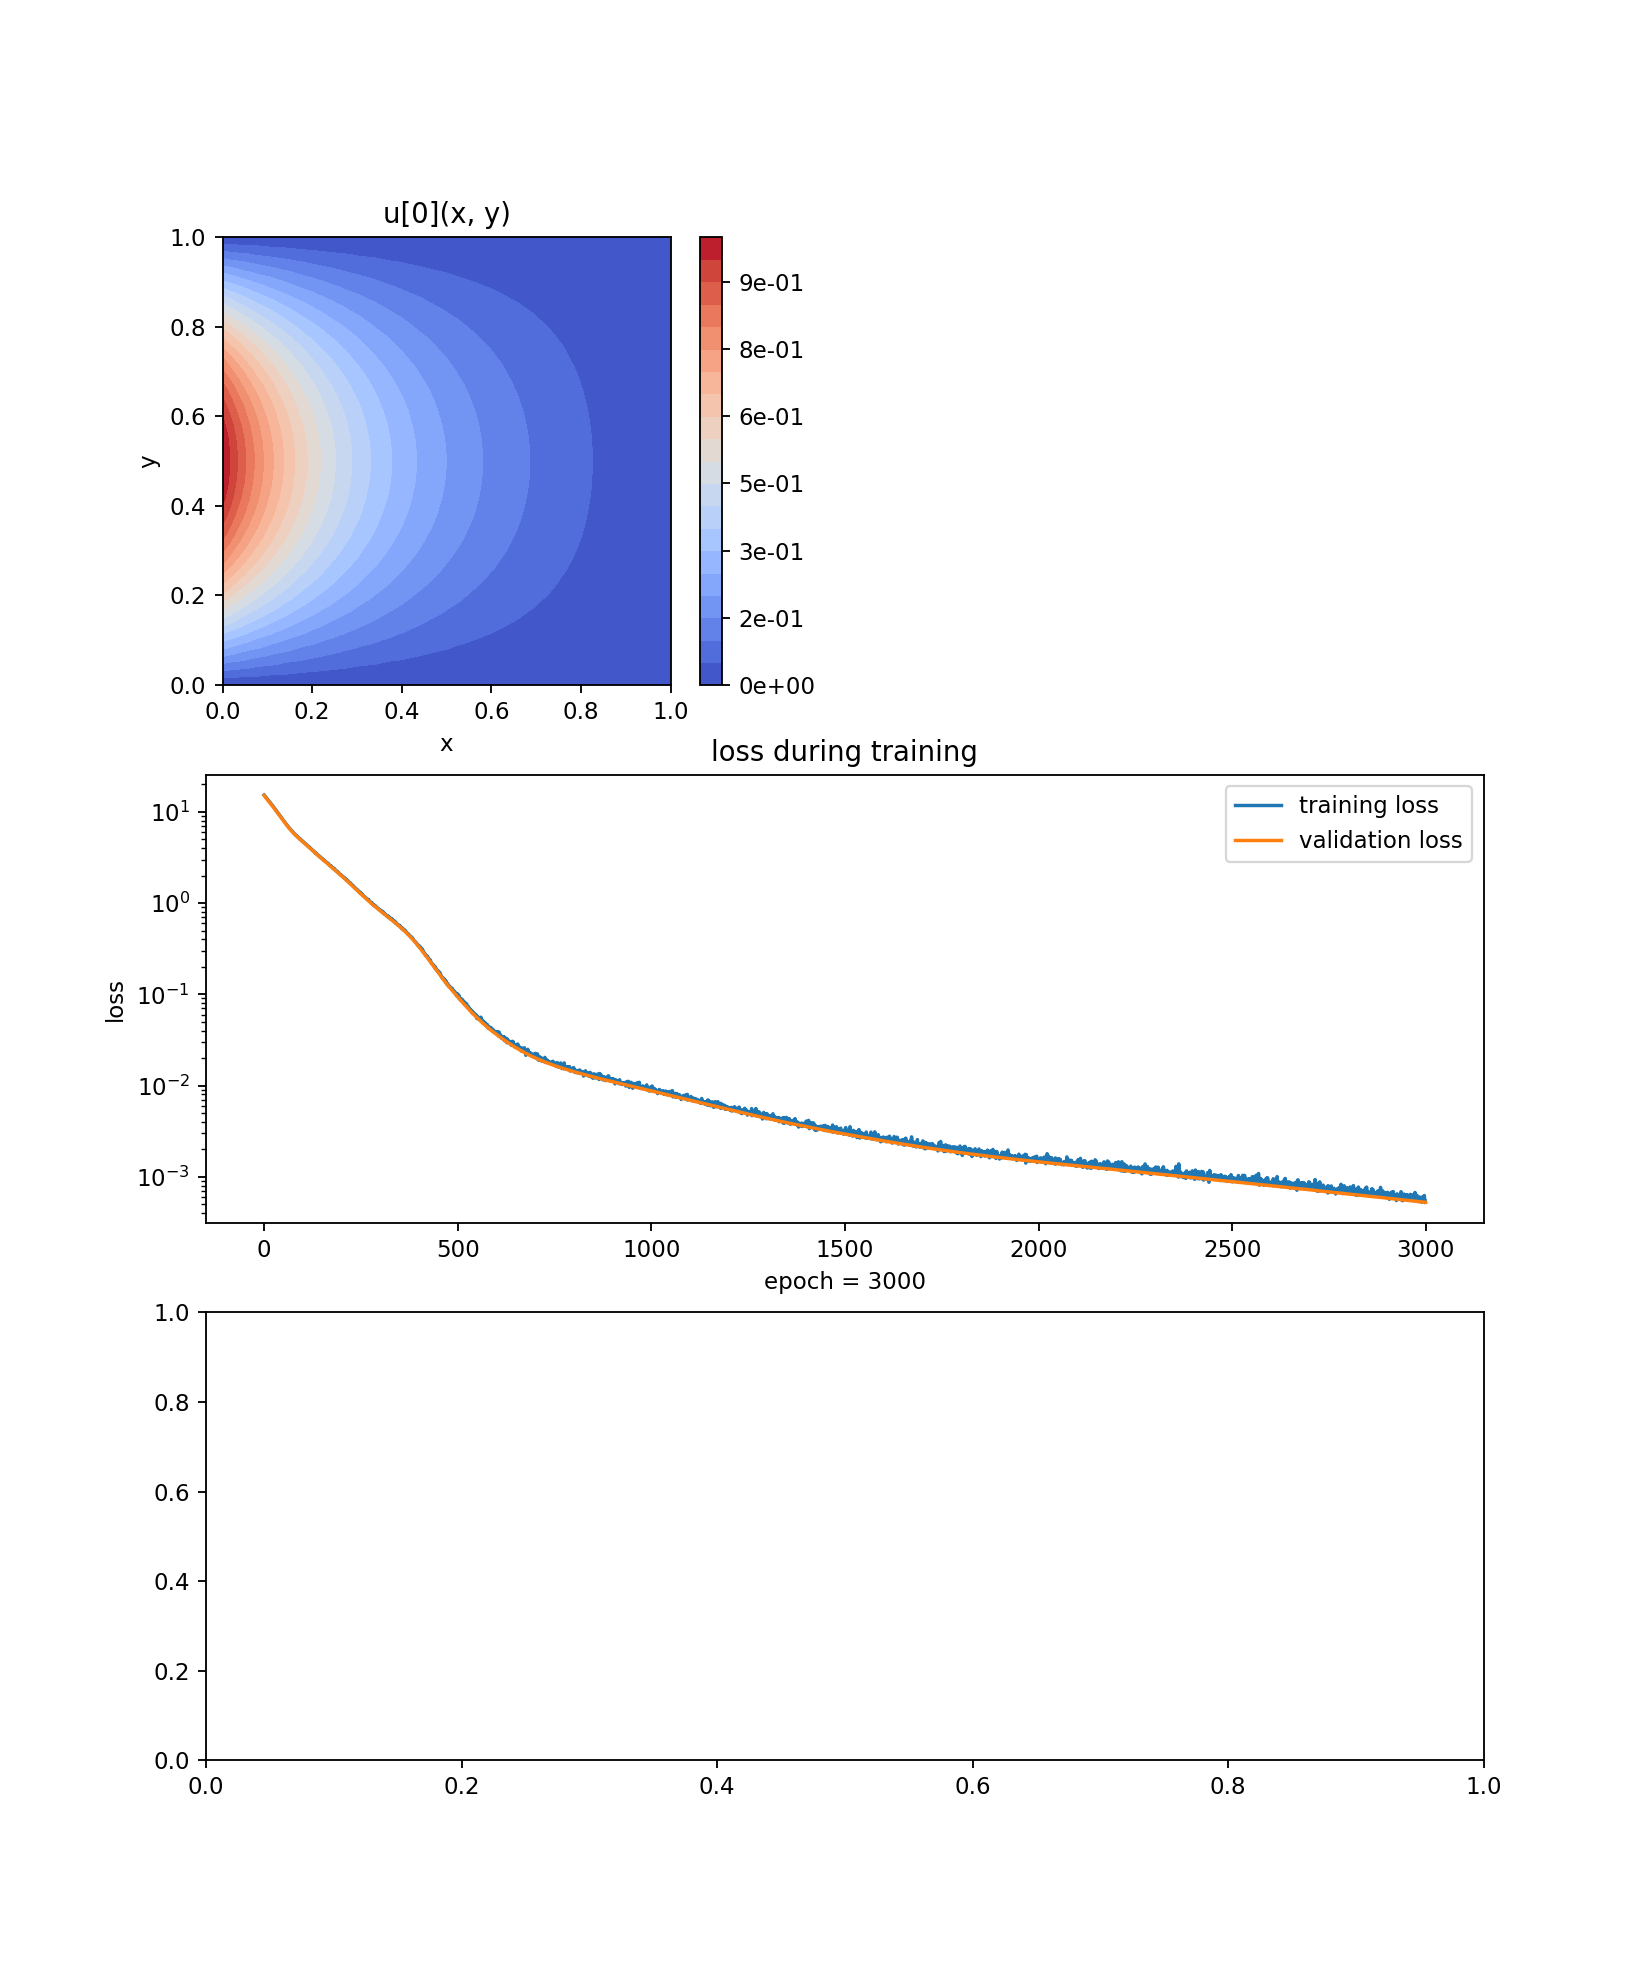

In [4]:
# Define the PDE system
# There's only one (Laplace) equation in the system, so the function maps (u, x, y) to a single entry
laplace = lambda u, x, y: [diff(u, x, order=2) + diff(u, y, order=2)]

# Define the boundary conditions
# There's only one function to be solved for, so we only have a single condition
conditions = [
    DirichletBVP2D(
        x_min=0, x_min_val=lambda y: torch.sin(np.pi*y), 
        x_max=1, x_max_val=lambda y: 0, 
        y_min=0, y_min_val=lambda x: 0, 
        y_max=1, y_max_val=lambda x: 0,
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=(32,32))
]

# Define the monitor callback
monitor=Monitor2D(check_every=100, xy_min=(0, 0), xy_max=(1, 1))
monitor_callback = monitor.to_callback()

# Instantiate the solver 
solver = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets,
    train_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver.fit(max_epochs=3000, callbacks=[monitor_callback])

# Obtain the solution
solution_neural_net_laplace = solver.get_solution()

## Train the ANN in the frequency field

We can escape F-principle when these neural networks are trained in real fields. Probably we can surpass this disadvantage by Fourier transform and inverse Fourier Transform?

In [25]:
harmonic_oscillator = lambda u, t: fft.fft([diff(u, t, order=2) + u])
init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=0.0)]

# specify the training set and validation set
train_gen = Generator1D(size=64,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = Generator1D(size=128, t_min=0.0, t_max=2*np.pi, method='equally-spaced')

# specify the neural network architecture
nets_ho1 = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(64, 64), actv=SinActv)]

solver1 = Solver1D(
    ode_system=harmonic_oscillator, 
    conditions=init_val_ho, 
    t_min=0.0, t_max=2*np.pi, 
    nets=nets_ho1,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)


# Fit the solver (i.e., train the neural networks)
solver1.fit(
    max_epochs=3000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

# Get the solution
solution_ho1 = solver1.get_solution()

<IPython.core.display.Javascript object>

Training Progress:   0%|                                                                      | 0/3000 [00:00<…

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.